<a id="top"></a>
<h1 align="center">MCMC Tutorial Part 1</h1>

<br>

**Authors:** John Letey, Mingxuan Zhang, H. Nihar Nandan, and Tony E. Wong

Not a lot of people know about the glory of Markov Chains, and not a lot of people know a lot about Monte Carlo simulation. In this set of tutorials, we hope to demystify both of the topics stated above.

In this specific part of the tutorials, we are going to talk about how to combine Markov Chains and Monte Carlo simulation. We will go over linear model, parameter estimation problems, and we will show you how Metropolis-Hastings algorithm works and what algorithms we can use to improve it.

<span style="color:blue">**JL + MZ:** DONE</span>

<span style="color:gray">**TW:**
This would be a great place to offer a brief overview of what this chapter is about. Just a sentence or two.
</span>

### Table of Contents

- [Packages](#packages)
- [Linear Model and Parameter Estimation](#lmpe)
- [Generate Synthetic Data](#synthetic-data)
- [Log-Likelihood Function](#log-likelihood)
- [Log-Prior Distribution](#log-prior)
- [Log-Posterior Distribution](#log-posterior)
- [Markov Chains](#markov-chains)
- [Metropolis-Hastings Algorithm](#mh-algo)
- [Convergence/Stationarity Diagnostics](#cs-diag)
- [Thinning](#thinning)
- [Adaptive Metropolis-Hastings](#amh)
- [References](#refs)

<a id="packages"></a>
***
<h2 align="center">Packages</h2>
[Back to top](#top)

<br>

These are all of the packages we are going to be using:

In [3]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
from pprint import pprint
# %load_ext blackcellmagic

COLORS = ["skyblue", "steelblue", "gray"]
ALPHAS = [1.0, 1.0, 0.45]

***

<a id="lmpe"></a>
***
<h2 align="center">Linear Model and Parameter Estimation</h2>
[Back to top](#top)

<br>

Let's say we have a linear model that simulates the amount of ice cream you will consume (where $y$ has units of pints) after going on a bike ride of length $x$ (where $x$ has units of miles). So the true process model, based on the unknown true values of the slope and intercept parameters, which we can call $\alpha^*$ and $\beta^*$, is:

$$y_{true} = \alpha^*x  +  \beta^*$$

We want to make this more realistic by incorporating some normally-distributed uncertainty, for instance, with mean $0$ and standard deviation $\sigma$.  Call these uncertain measurements $y_{meas}$:

$$y_{meas} = y_{true}  +  \epsilon = \alpha^*x  + \beta^*  +  \epsilon$$

where $\epsilon \sim N(0, \sigma)$ is our normally-distributed measurement error. We now want to estimate $\alpha$ and $\beta$. Let us call $\hat{\alpha}$ and $\hat{\beta}$ our estimates of these parameters. They lead to a set of estimates of the response, $\hat{y}$:

$$\hat{y} = \hat{\alpha}x  +  \hat{\beta}$$

This is then a parameter estimation problem, where our task is to compute estimates, $\hat{\alpha}$ and $\hat{\beta}$, of the unknown true model parameters, $\alpha^*$ and $\beta^*$, such that our model $\hat{y}$ best represents the observations $y_{meas}$, in light of the uncertainties $\epsilon$. We will tackle this problem through **Bayesian model calibration**, wherein we will integrate possible prior knowledge regarding the parameters with the information from observational data.
***

<a id="synthetic-data"></a>
***
<h2 align="center">Generate Synthetic Data</h2>
[Back to top](#top)

<br>

We will generate some synthetic data using our linear model, as described above, in order to demonstrate the Bayesian calibration approach. Suppose we keep track of our ice cream consumption after 100 bicycle rides, varying in length (uniformly) between 0 and 10 miles. For each of these ride lengths, we can use the linear model above to estimate the true ice cream consumption for each ride, and then add in the Gaussian residuals $\epsilon$. In this particular case, let $\alpha^* = 0.5$ and $\beta^* = 8$, which represent the true parameters for our linear model, which also means for every additional mile we bike, we consume $0.5$ pints ice cream where the baseline ice cream consumption is $8$ pints.


<span style="color:blue">**JL + MZ:** DONE</span>

<span style="color:gray">**TW:**
Let's add a sentence interpreting the true physical process model going on here. That is, for every additional mile we bike, we consume ... ice cream and ... baseline ice cream consumption...
</span>

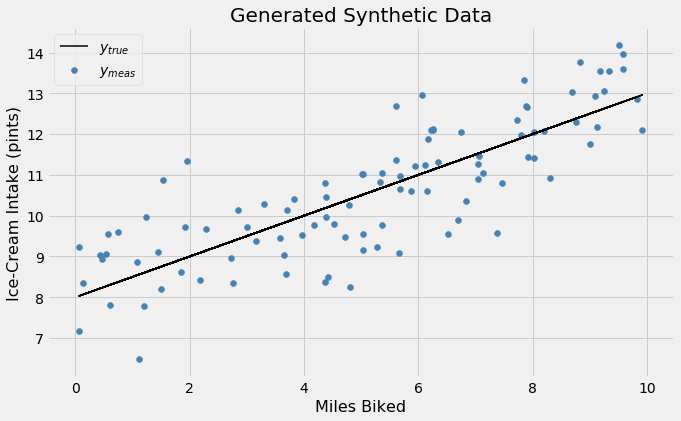

In [4]:
def generate_synthetic_data(astar, bstar, sigma, random_seed=1234, plot=False):
    np.random.seed(random_seed)  # set the seed for sampling.
    # the x values.
    x = np.random.uniform(0, 10, size=100)
    # the true y values.
    y_true = [astar * x_ + bstar for x_ in x]
    # the synthetic y values.
    y_meas = [stats.norm.rvs(loc=y, scale=sigma) for y in y_true]
    # plot if the user wants to
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(x, y_true, lw=1.5, color="k", label=r"$y_{true}$")
        plt.scatter(x, y_meas, color="steelblue", label=r"$y_{meas}$")
        plt.title("Generated Synthetic Data", fontsize=20)
        plt.xlabel("Miles Biked", fontsize=16)
        plt.ylabel("Ice-Cream Intake (pints)", fontsize=16)
        plt.legend()
        plt.show()
    # return the generated data
    return np.array(x), np.array(y_true), np.array(y_meas)


x, y_true, y_meas = generate_synthetic_data(astar=0.5, bstar=8, sigma=1, plot=True)

***

<a id="log-likelihood"></a>
***
<h2 align="center">Log-Likelihood Function</h2>
[Back to top](#top)

<br>

The likelihood function describes the plausibility of a parameter value based on observations. Generally, we seek parameter values that maximize the likelihood function. For this example, since we know that the observed-true $y$ residuals are normally distributed with mean $0$ and standard deviation $\sigma$, we will use the product of normal distributions for each observed-true $y$ residuals to represent the likelihood function (note that this only works if the residuals are also independent as well):

<span style="color:blue">**JL:** DONE</span>

<span style="color:gray">**TW:**
residuals need to be **independent** too
</span>

$$L(y_{meas} \mid (\hat{\alpha}, \hat{\beta})) = \prod_{i=1}^N \frac{1}{\sqrt{2\pi\sigma^2}}e^{-(\hat{y}_i-y_i)/2\sigma^2}$$

where $\hat{y} = \hat{\alpha} x + \hat{\beta}$ (evaluated at the `x_true` points).

<span style="color:gray">**TW:**
yhat is alpha-hat x + betae-hat (I fixed it)
</span>

In this analysis, you will work with the **log-probability distributions** for numerical stability reasons. That is, the probabilities involved may be very small, and computers may not be able to distinguish them from 0 in many cases. Thus, the formula for the log-likelihood function is as follows:

$$LL(y_{meas} \mid (\hat{\alpha}, \hat{\beta})) = \sum_{i=1}^N \log\left(\frac{1}{\sqrt{2\pi\sigma^2}}e^{-(\hat{y}_i-y_i)/2\sigma^2}\right)$$

Note, that the whole $\frac{1}{\sqrt{2\pi\sigma^2}}e^{-(\hat{y}_i-y_i)/2\sigma^2}$ is just the normal probability distribution function (pdf) evaluated at $\hat{y}_i-y_i$ with a mean $0$ and standard deviation $\sigma$. Also note that when we implement the log-likelihood function in code, we will use the SciPy implementation of the normal pdf (`scipy.stats.norm.pdf`).


<br>

<span style="color:blue">**JL:** DONE</span>

<span style="color:gray">**TW:**
Let's include an equation with the log-likelihood, to show it as a sum
</span>

<span style="color:blue">**JL:** DONE</span>

<span style="color:gray">**TW:**
Below, the function uses the equation for a normal pdf, and expands it when taking the log. We should  show the full normal pdf in the likelihood and log-likelihood equations before it shows up in the function, sort of out of nowhere. Alternatively, call the scipy.stats.norm.pdf function (and add a sentence saying that we"ll do that)
</span>

In [5]:
def loglikelihood(theta, y, sigma=1):
    model = theta[0] * x + theta[1]
    resid = y - model
    return np.sum(stats.norm.logpdf(resid, loc=0, scale=sigma))

***

<a id="log-prior"></a>
***
<h2 align="center">Log-Prior Distribution</h2>
[Back to top](#top)

<br>

The prior distribution is the probability of an event or observation, before taking into account the evidence. For this example, we will use a uniform prior distribution for $\alpha$ and $\beta$. Here, we will assume that $\alpha$ and $\beta$ are independent, so their prior distribution simplifies to $\pi(\alpha, \beta) = \pi(\alpha) \pi(\beta)$. But similarly to likelihood, we should build up the log-prior, so $\log(\pi(\alpha, \beta)) = \log(\pi(\alpha)) + \log(\pi(\beta))$.

To use uniform distribution, we need upper bound and lower bound to define the pdf, so the upper and lower bounds for $\alpha$ are 100 and 0 and the bound for $\beta$ are also 100 and 0.

<span style="color:blue">**JL:** DONE</span>

<span style="color:gray">**TW:**
Have we defined the abbreviation "pdf" yet? Check above. If not, here we should say "probability density function (pdf)"
</span>

<span style="color:blue">**JL + MZ:** DONE</span>

Notice that these bounds may be unrealistically wide: it"s unlikely that you will consume $100$ pints of ice cream even before you start to ride a bike and it"s also unlikely that you will consume $100$ pints of ice cream after only biking one mile. But we want to show that this procedure still works even if we have weak prior knowledge.

<span style="color:gray">**TW:**
Include a sentence noting that these bounds may be unrealistically wide, but we want to illustrate that this procedure still works even if we have weak prior knowledge (or "relatively uninformative" priors)
</span>

<span style="color:blue">**JL + MZ:** DONE</span>

<span style="color:gray">**TW:**
When you talk about the likelihood function and prior, make a note somewhere that there are maximum likelihood methods, but the strength of a *Bayesian* model calibration approach is to use the likelihood function *AND* incorporate any prior knowledge
</span>

So the prior distribution will be:
$$\log(\pi(\alpha, \beta)) = \log(\pi(\alpha)) + \log(\pi(\beta)) = \log\left(\dfrac{1}{100}\right) + \log\left(\dfrac{1}{100}\right) $$

<span style="color:gray">**TW:**
prior ought to be a piecewise function that is 1/100 only between 0 and 100, and 0 outside that range. for example:

$$\pi(\alpha) = \begin{cases} \dfrac{1}{100} & \text{if}~0 \leq \alpha \leq 100 \\ 0 & \text{otherwise} \\ \end{cases}$$
</span>

$$\pi(\beta) = \begin{cases} \dfrac{1}{100} & \text{if}~0 \leq \beta \leq 100 \\ 0 & \text{otherwise} \\ \end{cases}$$
</span>

Since we are trying to maximize the likelihood function, there are maximum likelihood methods, but the strength of a *Bayesian* model calibration approach is to use the likelihood function *AND* incorporate any prior knowledge.

<span style="color:gray">**TW:**
FYI:  I changed the parentheses on the logs above to be the ones that will match the size of whatever they surround: \left( and \right)
</span>

In [6]:
def logprior(theta):
    alpha, beta = theta
    if alpha < 0 or alpha > 100 or beta < 0 or beta > 100:
        return -np.inf
    else:
        return np.log(1 / 100) + np.log(1 / 100)

***

<a id="log-posterior"></a>
***
<h2 align="center">Log-Posterior Distribution</h2>
[Back to top](#top)

<br>

The posterior distribution is defined as being the probability that an event or observation will occur after taking into account all evidence and background (i.e., prior) information, in light of the uncertainties in both the parameters and the observations. Bayes" theorem defines the posterior probability as proportional to the likelihood of the observations given the parameters times the prior probability of the parameters:

$$\text{posterior distribution} = \pi((\alpha, \beta) \mid y_{meas}) \propto L(y_{meas} \mid (\alpha, \beta)) \times \pi(\alpha, \beta)$$

where $L(y_{meas} \mid (\alpha, \beta))$ is the likelihood function and $\pi(\alpha, \beta)$ is the prior distribution for alpha and beta.

The posterior distribution summarizes information about the parameters based on the prior distribution and what the likelihood function says about more "likely" parameter values.

<span style="color:blue">**JL + MZ:** DONE</span>

<span style="color:gray">**TW:**
put a comment or two into the code below saying what all is going on. especially to point out the possible inefficiency of executing the likelihood function in situations where the prior probability is 0 (lprior=-inf)</span>


In [7]:
def logpost(theta, y, sigma=1):
    # let's first calculate the log-prior probability.
    lprior = logprior(theta)
    # if the log-prior probability is negative infinity, it would be redundant to
    # calculate the log-likelihood since we know that there sum would be negative
    # infinity no matter what.
    if lprior == -np.inf:
        return -np.inf
    # if the log-prior probability is not negative infinity, then we can calculate
    # the log-likelihood and then find the posterior.
    ll = loglikelihood(theta, y, sigma)
    return ll + lprior

***

<a id="markov-chains"></a>
***
<h2 align="center">Markov Chains</h2>
[Back to top](#top)

<span style="color:blue">**JL:** DONE</span>

<span style="color:gray">**TW:**
follow same h2 centered heading  throughout if that's what is being used
</span>

A Markov chain is a stochastic model describing a sequence of possible events in which the probability of each event depends only on the state attained in the previous event. 

Let's begin with one simple example to introduce the basic idea of markov chains. Suppose the $X_{n}$ is the weather condition on day $n$ in Boulder, CO, which is either $0 \Rightarrow \text{rainy}$, or $1 \Rightarrow \text{sunny}$. Suppose we know that if the current day is sunny then the probability that the following day is also going to sunny is $0.9$, and if the current day is rainy then the probability that the following day is also going to be rainy is $0.3$. Thus, we have four transititon probailities:

$$
\begin{aligned}
P(X_{n+1} = 1 \mid X_{n} = 1) &= 0.9 \\
P(X_{n+1} = 1 \mid X_{n} = 0) &= 1- 0.9 = 0.1 \\
P(X_{n+1} = 0 \mid X_{n} = 0) &= 0.3 \\
P(X_{n+1} = 0 \mid X_{n} = 1) &= 1- 0.3 = 0.7
\end{aligned}
$$

At this point in time, you might be wondering what is the probability that day $n+1$ is sunny given we know all the weather conditions from day $0$ to $n$. This can be represented by the probability

$$ P(X_{n+1} = 1 \mid X_{n}, X_{n-1}, X_{n-2}. ......., X_{0}) = ? $$

Fortunately, since we have the four transition probabilities, we only need to know the weather condition at day $n$ to obtain that specific probability. Therefore, any other information about the past is conditionally independent, given $X_n$ for predicting $X_{n+1}$, thus:

$$ P(X_{n+1} = 1 \mid X_{n}, X_{n-1}, X_{n-2}. ......., X_{0}) = P(X_{n+1} = 1 \mid X_{n}) $$

This is what we mean when we say "the probability of each event depends only on the state attained in the previous event."

This property is also known as first-order Markov property, which is:

- Past and future are independent of the present
- State at $t+1$ only depends on state at $t$

<span style="color:blue">**JL + MZ:** DONE</span>

<span style="color:gray">**TW:**
use the phrase "conditionally independent, given $X_n$" or something like that, instead of "irrelevant" (irrelevant sounds kind of harsh and dismissive)
</span>

<span style="color:gray">**TW:**
Include definition of the (first-order) Markov property when discussing this independnence
</span>
***

<a id="mh-algo"></a>
***
<h2 align="center">Metropolis-Hastings Algorithm</h2>
[Back to top](#top)

<span style="color:blue">**JL:** DONE</span>

<span style="color:gray">**TW:**
centered?
</span>

Now, let's go back to the linear model and parameter estimation problem: our goal is to find the good parameters for this ice cream consumption model. One of the ways we can do this is by using the Metropolis-Hastings algorithm and markov chains:

The Metropolis-Hastings algorithm will help us find good parameters and save them (our log-posterior function can tell us how good are they), if it is better than the current one, we will accept it and use the parameters we accepted as our next starting point to explore more parameters with a fixed step size. However, if it isn"t better, we still can accept it with some probability ... intuitively, if the proposed parameters are really bad (low log-posterior score) we want the acceptance probability to be low too. If they are close to our current parameters, we want the the acceptance probability to be higher. We can do that by carefully using our log-posterior function to save all the parameters we accepted. When the algorithm ends, we will have a long markov chain! Below is a rough sketch of the Metropolis-Hastings algorithm:


> **Metropolis-Hastings Algorithm (MCMC):**
  * start the algorithm with some initial parameter estimates $\alpha_0$ and $\beta_0$ as your current state
  * use your **current state** and the **fixed step size** for now to propose the next move by the multivariate normal distribution and calculate the corresponding log-posterior score, here the current state and the fixed step size are the mean and covariance matrix parameters for multivariate normal distribution.
  * probability of accepting a proposed move at iteration $t$ is the ratio of the **posterior scores** for the current and the proposed states:
  $$p_{accept} = min\left(\dfrac{\pi(\alpha_{new}, \beta_{new} \mid y_{meas})}{\pi(\alpha_{t}, \beta_{t} \mid y_{meas})}, 1\right)$$
  where $\pi(\alpha, \beta \mid y_{meas})$ is the posterior score for the parameter value $\alpha, \beta$, given the data.
    * if we accept the proposed move, then the next $\left(\alpha_{t+1},  \beta_{t+1}\right)$ is set to $\left(\alpha_{new}, \beta_{new}\right)$
    * if we reject the proposed move, then the next $\left(\alpha_{t+1}, \beta_{t+1}\right)$ is set to $\left(\alpha_t, \beta_t\right)$ ... no change in state
    * since we are using log-posterior score instead of posterior score, we have to do some algebra to make this work
  $$
  \begin{aligned}
  \log{\left(p_{accept}\right)} &= \log{\left(\dfrac{\pi(\alpha_{new}, \beta_{new} \mid y_{meas})}{\pi(\alpha_{t}, \beta_{t} \mid y_{meas})}\right)} = \log{(\pi(\alpha_{new}, \beta_{new} \mid y_{meas}))} - \log{(\pi(\alpha_{t}, \beta_{t} \mid y_{meas}))} \\
  \exp{\left[\log{\left(p_{accept}\right)}\right]} &= p_{accept} = \exp{\left[\log{\left(\pi(\alpha_{new}, \beta_{new} \mid y_{meas})\right)} - \log{(\pi(\alpha_{t}, \beta_{t} \mid y_{meas}))}\right]}
  \end{aligned}
  $$
  * save **all** of the previous parameter states and corresponding log-posterior scores so that they can tell you something about your system
  * do this for some large number $N$ of iterations ($t=0, 1, 2, \ldots, N$)

<br>


<span style="color:blue">**JL + MZ:** DONE</span>

<span style="color:gray">**TW:**
Haha... okay, split the difference.  We certainly still want to include steps like "Start with some initial parameter estimates $\alpha_0$ and $\beta_0$"...  and the random draw of new parameters $\alpha_{new}$ and $\beta_{new}$...
</span>

### Stationary Distribution

Our goal is to sample from posterior distribution, so we want to show that the Metropolis-Hastings algorithm will in fact achieve this goal, to show that, we will use two facts:

Fact 1: Markov chain converges to a target distribution, if the target distribution is irreducible, recurrent, and aperiodic.

Fact 2: If we choose the acceptance probability as in Metropolis-Hastings algorithm, the target distribution will be posterior distribution.



To use the multivariate normal distribution to propose a next move, we need to specify the covariance matrix parameter, which is the step size in our case. Note that for the Metropolis-Hastings algorithm, we will use a fixed step size. Different step sizes will give us different markov chains: our goal here is to pick a good step size. Now, how do we determine whether the stepsize is a good or bad stepsize? We will use the **acceptance rate** which is used to see how the Markov chain is constructed. We can calculate the acceptance rate by using the number of times we accept the proposed move divided by the number of iterations.

In general, the step size should be chosen so that the acceptance rate is far from $0$ and far from $1$ ([Rosenthal 2010](#Rosenthal-2010)). The optimal acceptance rate varies depending on the number of dimensions in the parameter space. As the number of dimensions in the parameter space increases, the optimal acceptance rate goes to about $23.4\%$ ([Roberts etal 1997](#Roberts-etal-1997); [Rosenthal 2010](#Rosenthal-2010)). But for a single parameter, it is about $44\%$ ([Rosenthal 2010](#Rosenthal-2010)). For $2$ parameters, it is likely higher than $23.4\%$.


<span style="color:blue">**JL + MZ:** DONE</span>


<span style="color:gray">**TW:**
Describing this in your own words, not quoations from any textbook or what not.
</span>

<span style="color:gray">**TW:**
the code below can be used to inform how the pseudocode for the algorithm looks above. Make sure the two run parallel to one another, and include plenty of comments!
</span>

<span style="color:gray">**TW:**
Introduce concept of the proposal step sizes, and the "Goldilocks" notion of what is ideal (44% for a single parameter, 23.4% as the number of parameters goes to infinity; someone besides John should dig up the references for these, which are probably in my GMD BRICK paper)
</span>


(The history_plots and sequences_generator functions are two helper functions, they don't belong to the body our metropolis-hastings algorithm)

In [8]:
def history_plots(mcmc_chains, params, true_params=None):
    m = len(mcmc_chains)
    fig, ax = plt.subplots(nrows=1, ncols=len(params), figsize=(16, 6))
    fig.suptitle("History Plots", fontsize=20)
    for i in range(len(params)):
        for j in range(m):
            ax[i].plot(
                mcmc_chains[j][i],
                label="Sequence {0}".format(j + 1),
                color=COLORS[j % 3],
                alpha=ALPHAS[j % 3],
            )
        if true_params is not None:
            ax[i].plot(
                ax[i].get_xbound(),
                [true_params[i], true_params[i]],
                color="black",
                linestyle="dashed",
                label=params[i] + " true value",
                linewidth=2.5,
            )
        ax[i].set_xlabel("Iteration", fontsize=16)
        ax[i].set_ylabel(params[i] + " Trace", fontsize=16)
        ax[i].legend(loc="best")
    plt.show()

In [9]:
def sequences_generator(m, n_iter, stepsize, y_meas=y_meas, logpost=logpost):
    problems = []
    for i in range(m):
        alphai = np.random.randint(low=0, high=1)
        betai = np.random.randint(low=0, high=10)
        theta = [alphai, betai]
        state = State(theta, logpost(theta, y_meas))
        problems.append(ProblemMCMC(state, logpost, stepsize, y_meas))
    ar, mcmc_chains, ls = [], [], []
    for i in range(m):
        alpha, beta, l, r = mcmc(problems[i], n_iter)
        mcmc_chains.append([alpha, beta])
        ar.append(r)
        ls.append(l)
    return mcmc_chains, ar, ls

In [10]:
class State:
    def __init__(self, state, value):
        # this is the variable where we keep the current state
        self.state = state 
        
        # this is the variable where we keep the corresponding log-posterior score
        self.value = value


class ProblemMCMC:
    def __init__(self, initial, logposterior, stepsize, y_meas):
        self.current = initial
        self.logpost = logposterior
        self.stepsize = stepsize
        self.y_meas = y_meas

    def random_move(self):
        next_move = stats.multivariate_normal.rvs(self.current.state, self.stepsize)
        return next_move, self.logpost(next_move, self.y_meas)

In [11]:
def mcmc(problem, n_iter):

    # want to keep growing these lists to track the parameter estimates and log-posterior score
    alpha = [problem.current.state[0]]
    beta = [problem.current.state[1]]
    lpost = [problem.current.value]
    
    # n_accept will keep tracking the number of times where we accept the proposed new move
    n_accept = 0
    
    #S is the number of times where we have proposed a new move
    S = 0
    
    np.seterr(over="ignore")
    for t in range(n_iter):
        S += 1
        
        # Here we will propose a new move
        nextMove, nextValue = problem.random_move()
        
        # calculate the acceptance probability and call it delta_obj
        delta_obj = np.exp(nextValue - lpost[-1])
        
        # the proposed move is an improvement, so accept w.p. 1
        if delta_obj > 1:
            n_accept += 1
            
            # keep tracking our states
            alpha.append(nextMove[0])
            beta.append(nextMove[1])
            lpost.append(nextValue)
            
            # the state in iteration t+1 will be proposed new move
            problem.current.state = nextMove
            problem.current.value = nextValue
            
        # the proposed move is worse; accept with probability we mentioned above
        else:
            p_accept = delta_obj
            accept = np.random.choice([True, False], p=[p_accept, 1 - p_accept])
            if accept:
                n_accept += 1
                
                # keep tracking our states
                alpha.append(nextMove[0])
                beta.append(nextMove[1])
                lpost.append(nextValue)
                
                # since we accept the new move, the state in iteration t+1 will be proposed new move
                problem.current.state = nextMove
                problem.current.value = nextValue
            else:
                
                # since we didn't accept the new move, the state in iteration t+1 will be the same as the state in iteration t
                # so we don't need to change the current state
                alpha.append(alpha[-1])
                beta.append(beta[-1])
                lpost.append(lpost[-1])

    return (alpha, beta, lpost, n_accept / S)

In [12]:
mcmc_chains, ar, ls = sequences_generator(3, 30000, [0.005, 0.01])
print("The acceptance rates for these markov chains are: ", end="")
pprint(ar)

The acceptance rates for these markov chains are: [0.2642, 0.26326666666666665, 0.26493333333333335]


Now that we have run the MCMC algorithm, let's take a look at the history plot for each parameter for each Markov chain ... a history plot is a plot of the iterations against the value of the estimated parameter at each of those iterations:

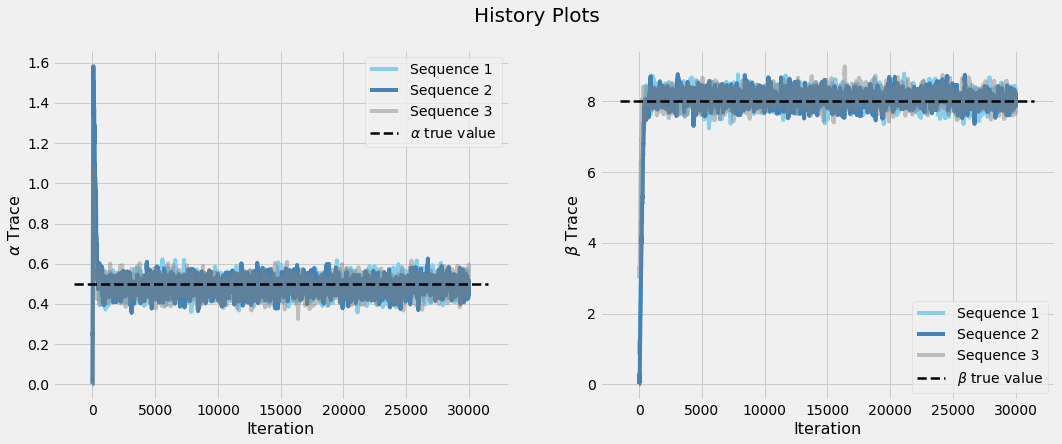

In [13]:
history_plots(mcmc_chains, [r"$\alpha$", r"$\beta$"], [0.5, 8])

<span style="color:blue">**JL + MZ:** DONE</span>

<span style="color:gray">**TW:**
Introduce what these plots are -- the very zoomed out history plots are not particularly useful, so zoom those WAY in. This might require you to narrow the prior range, which is totally fine too. </span>

<span style="color:blue">**JL + MZ:** DONE</span>

<span style="color:gray">**TW:**
histograms can be a bit smaller, and the trace plots can be correspondingly less wide
</span>

<span style="color:blue">**JL + MZ:** DONE</span>

<span style="color:gray">**TW:**
Can"t really see the trace plot because the dashed line for the true parameters is so thick and the view is so zoomed out.  Try to fix this so we can see everything. You could also just get rid of the dashed line for the true parameters in the history plots, but keep it in the histograms.
</span>

<a id="cs-diag"></a>
***
<h2 align="center">Convergence/Stationarity Diagnostics</h2>
[Back to top](#top)

<span style="color:blue">**JL + MZ:** DONE</span>

<span style="color:gray">**TW:**
header...
</span>

We want the Markov chains to reach the stationary distribution, but how can we tell whether they are in the stationary distribution? Fortunately, the Gelman and Rubin diagnostic assesses this using something called the "potential scale reduction factor". The potential scale reduction factor monitors the variance within the chain and compares it against the variance between the chains and if they look similar. If they are similar, then this is evidence for convergence. It is necessary to estimate the "between-chain variance", so you need to run at least one additional MCMC calibration to estimate the potential scale reduction factor ([Gelman-Rubin 1992](#Gelman-Rubin-1992)). 

<span style="color:blue">**JL + MZ:** DONE</span>

<span style="color:gray">**TW:**
add a reference to Gelman and Rubin (1992)
</span>

</n>

<span style="color:blue">**JL:** DONE</span>

<span style="color:gray">**TW:**
do we need to include this algo image?
</span>

> **Gelman-Rubin Diagnostic** - For each parameter, do these the following three steps:
  * Run $m \geq 2$ chains from overdispersed starting values.
  * Calculate the within-chain and between-chain variance.
  * Calculate the potential scale reduction factor.

The potential scale reduction factor is:
$$
\hat{R} = \sqrt{\frac{\hat{V}}{\sigma^2} \cdot \frac{\text{df}}{\text{df}-2}}
$$

where:
$$
\hat{V} = \hat{\sigma}^2 + \frac{B}{mn} \quad\text{and}\quad \hat{\sigma}^2 = \frac{n-1}{n}W + \frac{1}{n}B
$$

and also:
$$
\begin{aligned}
m &= \text{number of sequences} \\
n &= \text{length of each chain} \\
B &= \frac{n}{(m - 1)}.\Sigma(\mu_i - \bar{\mu})^2, ~~
\text{where $\mu_i$ is the average of each chain and $\bar{\mu}$ is the global mean of all estimated variables} \\
W &= \frac{1}{m}.\Sigma{\textrm{Var}_i}, ~~
\text{where }\textrm{Var}_i\text{ is the variance of sequence $i$} \\
\end{aligned}
$$

However, for the purposes of our tutorial, we will follow Gelman and Rubin (1992) and ignore the minor contribution of the degrees of freedom correction $df/(df-2)$. So our diagnostic will be calculated as:
$$
\hat{R} = \sqrt{\frac{\hat{V}}{\sigma^2}}
$$

<span style="color:blue">**JL + MZ:** DONE</span>

<span style="color:gray">**TW:**
HERE is where you need to define what all the quantities in that equation are (always, right after or before you introduce them) $$$$
Also -- I changed the period in the equation above to \cdot
</span>

<span style="color:gray">**TW:**
Turns out, Gelman and Rubin (1992) even say outright that "We ignore the minor contribution to variability in the factor df/(df-2)". So, I edited below to reflect this.</span>

<span style="color:gray">**TW:**
Have you defined what $\textrm{Var}_i$ is yet?
</span>

<span style="color:blue">**JL:** DONE</span>

<span style="color:gray">**TW:**
add some comments to the `diagnostic` function, to describe what each thing is in terms of the variables above
</span>

In [14]:
def GR_diag(parameter, interval=100, start=100):
    # go through each of the chains and calculate the
    # potential scale reduction factor
    end = len(parameter[0])
    m = len(parameter)
    GR_result = []
    for n in range(start, end, interval):
        sequences = []
        for i in range(m):
            sequences.append(parameter[i][:n])
        GR_result.append(psrf(sequences))
    burnin = 0
    for i in range(len(GR_result)):
        if max(GR_result[i:]) < 1.1:
            burnin = i+1
            break
    return GR_result, burnin*interval

def psrf(chains):
    # u_i - the average for each chain
    u = [np.mean(chain) for chain in chains]
    # s_i - the variance for each chain
    s = [np.var(chain, ddof=1) for chain in chains]
    # m - the number of sequences
    m = len(chains)
    # n - the length of each chain
    n = len(chains[0])
    # ubar - the overall average of the chains
    ubar = np.mean(u)
    # B, W - find the bewteen- and within-chain variance
    B, W = 0, 0
    for i in range(m):
        B += (u[i] - ubar)**2
        W += s[i]
    B = (B*n)/(m-1)
    W = W/m
    # Var - the overall variance of the chains
    Var = (1-(1/n))*W + (B/n)
    # R - the potential scale reduction factor
    return np.sqrt(Var/W)

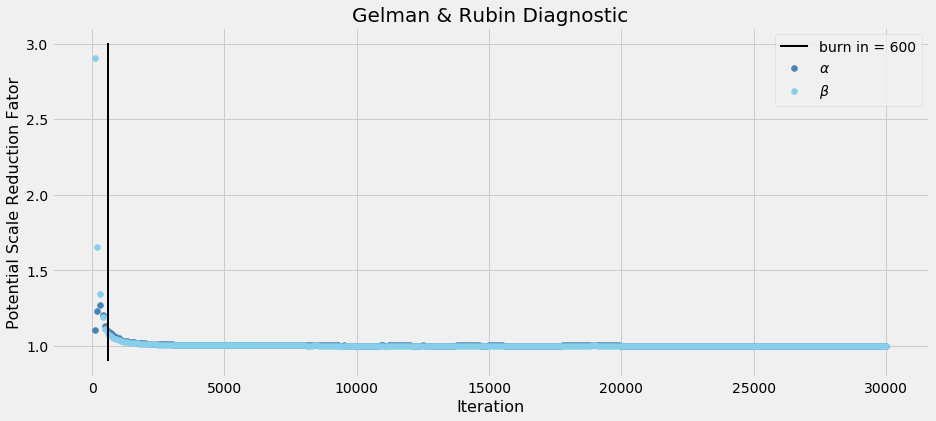

In [15]:
alpha_raw, beta_raw =[], []

for mcmc_chain in mcmc_chains:
    alpha_raw.append(mcmc_chain[0])
    beta_raw.append(mcmc_chain[1])

start, interval, end = 100, 100, len(alpha_raw[0])

GR_alpha, burnin_alpha = GR_diag(alpha_raw, interval, start)

GR_beta, burnin_beta = GR_diag(beta_raw, interval, start)

burnin = max([burnin_alpha, burnin_beta])

plt.figure(figsize=(14, 6))
plt.scatter(x=np.arange(start, end, interval), y=GR_alpha, label=r"$\alpha$", color="steelblue")
plt.scatter(x=np.arange(start, end, interval), y=GR_beta, label=r"$\beta$", color="skyblue")
plt.plot([burnin, burnin], plt.ylim(), label="burn in = {0}".format(burnin), color="black", linewidth=2)
plt.title("Gelman & Rubin Diagnostic", fontsize=20)
plt.xlabel("Iteration", fontsize=16)
plt.ylabel("Potential Scale Reduction Fator", fontsize=16)
plt.legend(loc="best")
plt.show()

<span style="color:blue">**JL + MZ:** DONE</span>


<span style="color:gray">**TW:**
What is number of values \* 100? 20 would then be 0.2 values...?  And we certaintly do not need to show such a wide x-range.  Only going out to 10 or 20 is probably fine because we only care about getting GR under 1.1. $$$$
Should show the **actual** number of simulations along the x-axis, and call the y-axis "Potential scale reduction factor"
</span>

***

<a id="thinning"></a>
***
<h2 align="center">Thinning</h2>
[Back to top](#top)

Now since we have the burn-in period, we can easily get the stationary distribution, so let's move on to next stage. We know the sequences of parameters we got from the MCMC algorithm are Markov chains, it is clear that the Markov chains are by definition dependent on previous iterates, but what we really want are independent draws from the stationary distribution. In order to do this, we need to figure out how far apart we must look before this dependence is forgotten. To achieve this, we can use the technique called thinning (aka, an auto-correlation function). The thinning process works by calculating the correlation of a sequence with itself given various lags. The lag describes an offset between the past states and future states, this value tells you how correlated past states are to future states, for different values of lag. Hence, intuitively, you"d expect the autocorrelation function to fall towards $0$ as the lag is getting larger and larger.

<span style="color:blue">**JL + MZ:** DONE</span>

<span style="color:gray">**TW:**
The logical flow is not quite right here.  We should start the section with our motivation: we want independent samples.  So, we look at autocorrelation.  We want autocorrelation to be low, because that means samples within the Markov chain aren"t correlated with one another beyond that lag. So try to clean and tighten up the paragraphs above and below here to reflect that.
</span>

<span style="color:gray">**TW:**
when defining autocorrelation, be sure to mention that this is the correlation of the time series with itself, but offset by a certain number of tiem steps -- aka, the `lag`
</span>

In [16]:
def ACF(X, end=200):
    N = len(X)
    acf = []
    for a in range(0, end):
        acf.append(np.corrcoef(X[a:], X[:N-a])[0][1])
        
    lag = -1
    for i in range(len(acf)):
        if acf[i] <= 0.05:
            lag = i
            break
    if lag == -1:
        print ("Please increase the value of the end parameter for this function")
    return lag, acf

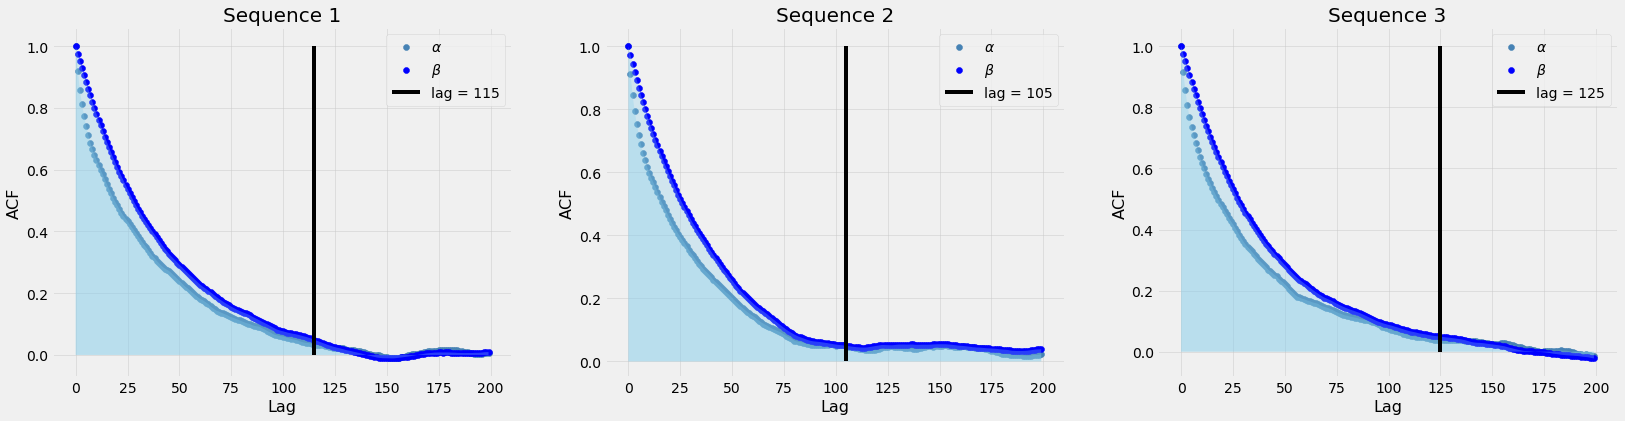

In [17]:
lag_alpha = []
lag_beta = []


acf_alpha = []
acf_beta = []


end = 200
for i in range(len(alpha_raw)):
    alpha_lag, alpha_acf = ACF(alpha_raw[i][burnin:], end)
    beta_lag, beta_acf = ACF(beta_raw[i][burnin:], end)
    
    lag_alpha.append(alpha_lag)
    lag_beta.append(beta_lag)
    
    acf_alpha.append(alpha_acf)
    acf_beta.append(beta_acf)
    

lags = [max([lag_alpha[i], lag_beta[i]]) for i in range(len(alpha_raw))]



fig, ax = plt.subplots(nrows=1, ncols=len(alpha_raw), figsize=(25,6))
for i in range(len(alpha_raw)):
    ax[i].scatter(np.arange(0, end), acf_alpha[i], label=r"$\alpha$", color="steelblue")
    ax[i].fill_between(x=np.arange(0, end), y2=np.zeros_like(acf_alpha[i]), y1=acf_alpha[i], alpha=0.3, facecolor="skyblue")
    ax[i].scatter(np.arange(0, end), acf_beta[i], label=r"$\beta$", color="blue")
    ax[i].fill_between(x=np.arange(0, end), y2=np.zeros_like(acf_beta[i]), y1=acf_beta[i], alpha=0.3, facecolor="skyblue")
    ax[i].vlines(x=lags[i], ymin=0, ymax=1, label="lag = {0}".format(lags[i]))
    ax[i].set_title("Sequence {0}".format(i+1), fontsize=20)
    ax[i].set_xlabel("Lag", fontsize=16)
    ax[i].set_ylabel("ACF", fontsize=16)
    ax[i].legend(loc="best")
    ax[i].grid(alpha=0.5)
plt.show()

<span style="color:blue">**JL + MZ:** DONE</span>

<span style="color:gray;font-size:25pt">**TW:**
&#x21E7; AAAAAAAAAAAAAHHHHHHHHHHHHH!!!!!!
</span>


For each chain we have a different ```lag``` value and in each chain, we have different values. We will select the largest of all these values which will ensure some level of certainty  that these values will be relatively independent when selected at these lag intervals. 

***

<a id="amh"></a>
***
<h2 align="center">Adaptive Metropolis-Hastings</h2>
[Back to top](#top)

Like we mentioned above, the Metropolis-Hastings algorithm uses a fixed step size, this requires us to find a good step size. But, sometimes it is very hard to find a good fixed step size. However, a bad fixed step size will lead to a non-convergent Markov chain. Here is some examples of Markov chains with bad fixed step sizes.

$$***$$

The acceptance rates for these markov chains are: [0.6045, 0.6086, 0.6099]


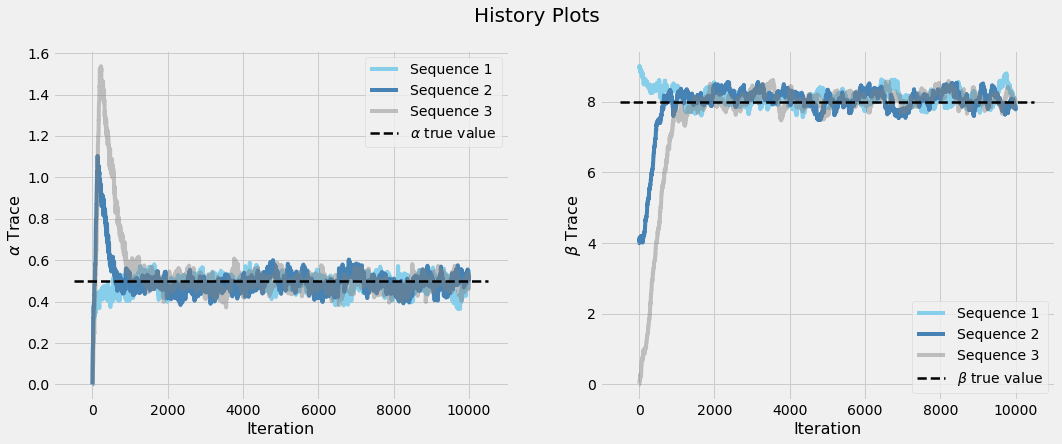

In [26]:
mcmc_chains, ar, ls = sequences_generator(3, 10000, [0.0005, 0.001])
print("The acceptance rates for these markov chains are: ", end="")
pprint(ar)
history_plots(mcmc_chains, [r"$\alpha$", r"$\beta$"], [0.5, 8])

This is the example where the step size is too small, so the acceptance rates are too high, because you are too timid in your exploration, the markov chains are not converging.

***

The acceptance rates for these markov chains are: [0.0096, 0.0122, 0.0086]


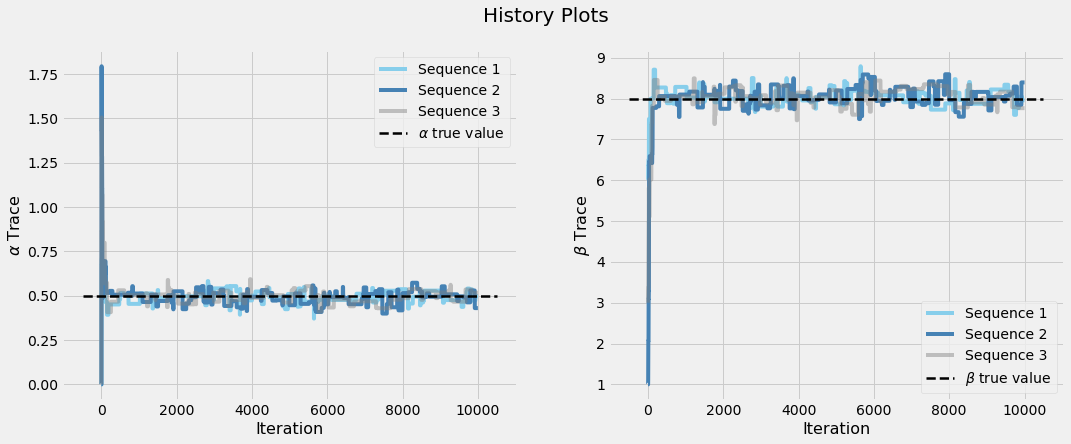

In [31]:
mcmc_chains, ar, ls = sequences_generator(3, 10000, [0.5, 0.9])
print("The acceptance rates for these markov chains are: ", end="")
pprint(ar)
history_plots(mcmc_chains, [r"$\alpha$", r"$\beta$"], [0.5, 8])

This is another example where the step size is too big, so the acceptance rates are too low, because you're leaping over good ones, the markov chains are not converging either.

$$***$$

So, instead of using fixed step size, we can learn from the markov chain and use all previous states to update our covariance matrix (step size), the algorithm we will use is from [Haario etal 2001](#Haario-etal-2001) for details of this algorithm refer to the paper.

<span style="color:blue">**JL + MZ:** DONE</span>

<span style="color:gray">**TW:**
Revise this to introduce the idea of step sizes being important, and relative step sizes. Note that we need a good proposal covariance matrix, and the number of elements to tune in it goes like $n^2$ where $n$ is the number of parameters to calibrate. So motivate the use of the adaptive metropolis... And simply introduce it and then reference Haario, instead of reviewing their work.
</span>


<span style="color:gray">**TW:**
Looks like the code below can be cleaned up in a manner consistent with the original codes above. $$$$ Make sure that the MCMC_chains code is **exactly** the same, except for a single line that updates the covariance, and just have a single helper function that does the update (update_cov)  $$$$ Use the resulting covariance matrix from this to inform a crude estimate for the "just right" step sizes in the motivation and acceptance rate discussion above. Pick something closer to the adapted covariance, because the one giving 26% acceptance above still looks a little rough.
</span>


In [33]:
def adaptive_sequences_generator(m, n_iter, stepsize, t, y_meas=y_meas, logpost=logpost):
    problems = []
    for i in range(m):
        alphai = np.random.randint(low=0.4, high=0.8)
        betai = np.random.randint(low=6, high=10)
        theta =[alphai, betai]
        state = State(theta, logpost(theta, y_meas))
        problems.append(AdaptiveMCMC(state, logpost, stepsize, y_meas, t))
    ar, mcmc_chains, ls = [], [], []
    for i in range(m):
        alpha, beta, l, r = adaptive_mcmc(problems[i], n_iter)
        mcmc_chains.append([alpha, beta])
        ar.append(r)
        ls.append(l)
    return mcmc_chains, ar, ls

In [34]:
eps = 0.0001

d = 2

I_d = np.identity(d)

S_d = (2.4)**2/d

def update_cov(X):
    cov = np.cov(X)
    return S_d*cov + I_d*eps*S_d

class AdaptiveMCMC: 
    def __init__(self, initial, logposterior, stepsize, y_meas, t):
        self.current = initial 
        self.logpost = logposterior 
        self.stepsize = stepsize 
        self.y_meas = y_meas
        self.t = t
        
    def random_move(self, t, X):
        if (t <= self.t):
            next_move = stats.multivariate_normal.rvs(self.current.state, self.stepsize)
        else:
            cov = update_cov(X)
            next_move = stats.multivariate_normal.rvs(self.current.state, cov)
        return next_move, self.logpost(next_move, self.y_meas)

In [35]:
def adaptive_mcmc(problem, n_iter):

    alpha = [problem.current.state[0]] 
    beta = [problem.current.state[1]]
    lpost = [problem.current.value]    
    n_accept = 0
    S = 0
    np.seterr(over="ignore")
    for t in range(n_iter):
        S += 1
        nextMove, nextValue = problem.random_move(t, [alpha, beta])
        delta_obj = np.exp(nextValue - lpost[-1]) 
        if delta_obj > 1:
            n_accept += 1
            alpha.append(nextMove[0])
            beta.append(nextMove[1])
            lpost.append(nextValue)
            problem.current.state = nextMove
            problem.current.value = nextValue
        else:
            p_accept = delta_obj
            accept = np.random.choice([True, False], p=[p_accept, 1-p_accept])
            if accept:
                n_accept += 1
                alpha.append(nextMove[0])
                beta.append(nextMove[1])
                lpost.append(nextValue)
                problem.current.state = nextMove
                problem.current.value = nextValue
            else:
                alpha.append(alpha[-1])
                beta.append(beta[-1])
                lpost.append(lpost[-1])

    return (alpha, beta, lpost, n_accept/S)

In [36]:
mcmc_chains, ar, ls = adaptive_sequences_generator(3, 30000, [0.005, 0.01], 1000)
print("The acceptance rates for these markov chains are: ", end="")
pprint(ar)

The acceptance rates for these markov chains are: [0.29456666666666664, 0.22023333333333334, 0.2135]


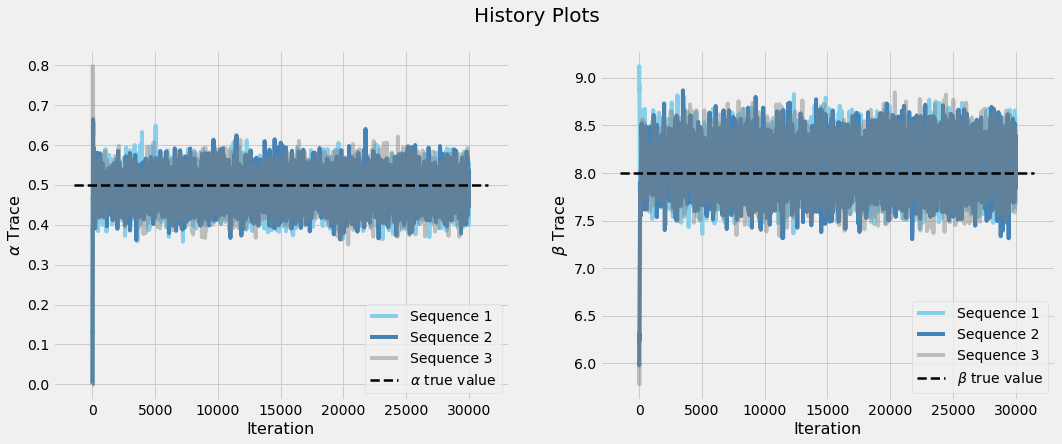

In [37]:
history_plots(mcmc_chains, [r"$\alpha$", r"$\beta$"], [0.5, 8])

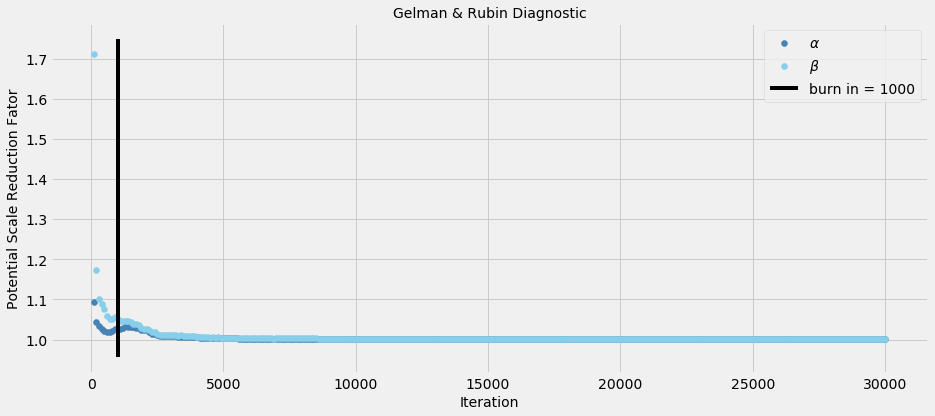

In [38]:
alpha_raw, beta_raw =[], []

for mcmc_chain in mcmc_chains:
    alpha_raw.append(mcmc_chain[0])
    beta_raw.append(mcmc_chain[1])

start, interval, end = 100, 100, len(alpha_raw[0])

GR_alpha, burnin_alpha = GR_diag(alpha_raw, interval, start)

GR_beta, burnin_beta = GR_diag(beta_raw, interval, start)

burnin = max([burnin_alpha, burnin_beta, 1000])

plt.figure(figsize=(14, 6))
plt.scatter(x=np.arange(start, end, interval), y=GR_alpha, label=r"$\alpha$", color="steelblue")
plt.scatter(x=np.arange(start, end, interval), y=GR_beta, label=r"$\beta$", color="skyblue")
ymin, ymax = plt.ylim()
plt.vlines(burnin, ymin=ymin, ymax=ymax, label="burn in = {0}".format(burnin))
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Potential Scale Reduction Fator", fontsize=14)
plt.title("Gelman & Rubin Diagnostic", fontsize=14)
plt.legend(loc="best")
plt.show()

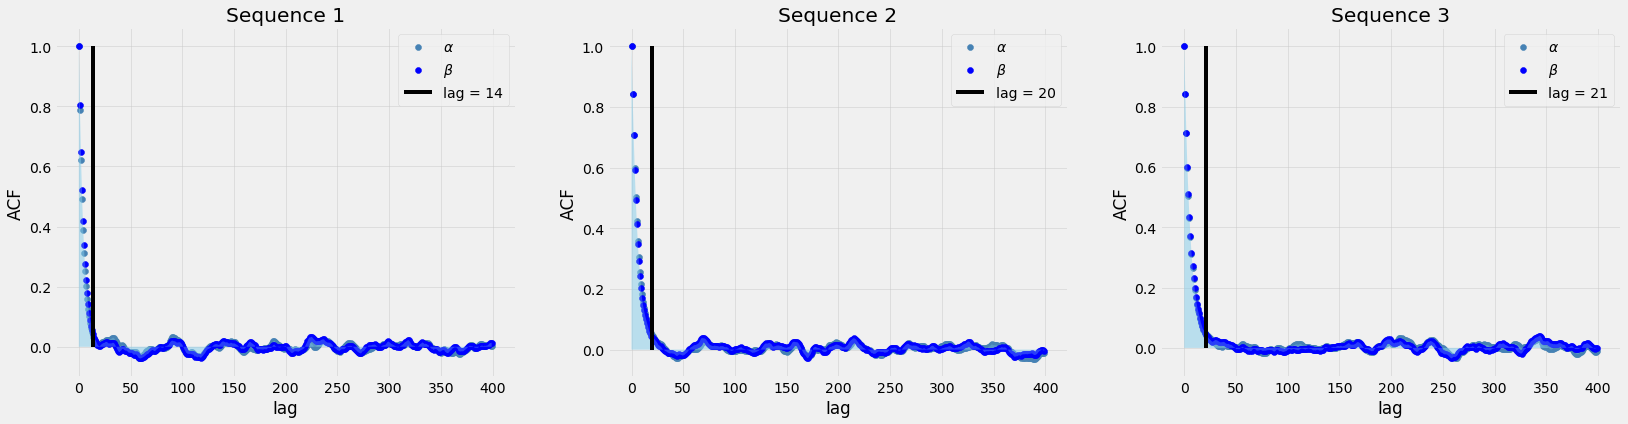

In [39]:
lag_alpha = []
lag_beta = []


acf_alpha = []
acf_beta = []


end = 400
for i in range(len(alpha_raw)):
    alpha_lag, alpha_acf = ACF(alpha_raw[i][burnin:], end)
    beta_lag, beta_acf = ACF(beta_raw[i][burnin:], end)
    
    lag_alpha.append(alpha_lag)
    lag_beta.append(beta_lag)
    
    acf_alpha.append(alpha_acf)
    acf_beta.append(beta_acf)
    

lags = [max([lag_alpha[i], lag_beta[i]]) for i in range(len(alpha_raw))]

m = len(mcmc_chains)

fig, ax = plt.subplots(nrows=1, ncols=len(alpha_raw), figsize=(25,6))
for i in range(m):
    ax[i].scatter(np.arange(0, end), acf_alpha[i], label=r"$\alpha$", color="steelblue")
    ax[i].fill_between(x=np.arange(0, end), y2=np.zeros_like(acf_alpha[i]), y1=acf_alpha[i], alpha=0.3, facecolor="skyblue")
    ax[i].scatter(np.arange(0, end), acf_beta[i], label=r"$\beta$", color="blue")
    ax[i].fill_between(x=np.arange(0, end), y2=np.zeros_like(acf_beta[i]), y1=acf_beta[i], alpha=0.3, facecolor="skyblue")
    ax[i].vlines(x=lags[i], ymin=0, ymax=1, label="lag = {0}".format(lags[i]))
    ax[i].set_xlabel("Iag")
    ax[i].set_ylabel("ACF")
    ax[i].set_title("Sequence {0}".format(i+1))
    ax[i].legend(loc="best")
    ax[i].grid(alpha=0.5)
plt.show()

<a id="refs"></a>
***
<h2 align="center">References</h2>
[Back to top](#top)

- <a id="Gelman-Rubin-1992"></a>Gelman, Andrew; Rubin, Donald B. Inference from Iterative Simulation Using Multiple Sequences.
Statist. Sci. 7 (1992), no. 4, 457--472. doi:10.1214/ss/1177011136. https://projecteuclid.org/euclid.ss/1177011136

$$***$$

- <a id="Haario-etal-2001"></a>Haario, Heikki; Saksman, Eero; Tamminen, Johanna. An adaptive Metropolis algorithm. Bernoulli 7 (2001), no. 2, 223--242. https://projecteuclid.org/euclid.bj/1080222083

$$***$$

- <a id="Rosenthal-2010"></a>Rosenthal, J. S. 2010. Optimal Proposal Distributions and Adaptive MCMC. Handbook of Markov chain
Monte Carlo. Eds., Brooks, S., Gelman, A., Jones, G. L., and Meng, X.-L. Chapman & Hall/CRC Press.
Available online at https://pdfs.semanticscholar.org/3576/ee874e983908f9214318abb8ca425316c9ed.pdf

$$***$$

- <a id="Roberts-etal-1997"></a>Roberts, G. O., Gelman, A., and Gilks W. R. 1997. Weak convergence and optimal scaling of random walk
Metropolis algorithms. Ann. Appl. Prob. 7, 110–120. Available online at http://projecteuclid.org/download/pdf_1/euclid.aoap/1034625254

***